# QBIO 465 Final Project

My final project seeks to build a fusion model in which three different data types will be fed into three different models in which their outputs wil then be concatenated to predict the final output value.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statistics as stat

## Functions to process input Data

In [3]:
def reorder_df (df):
    # this will add  an additional column for ligand used (i.e. 'MMMMM')
    # returns new dataframe with addtional ligand column
    ligand_name = []
    protein_name = []
    for name in df.iloc[:,0]:
        ligand_name.append(name.split('_')[-1])
        protein_name.append(name.split('_')[1])

    df['Protein'] = protein_name
    df.rename(columns={df.columns[1]: "iteration"}, inplace=True)
    df.insert(1, 'ligand', ligand_name)

    return df


def create_combined_binding_dict (df):
    # for each unique ligand, combine all binding poses into one list
    # return dictionary where keys are the unique ligands and values are lists of all binding energy poses for given ligand
    keys = set(df['ligand'])
    allBinding_dict = {key: [] for key in keys}
    for index in range(len(df.iloc[:,0])):
        ligand = df.loc[index,'ligand']
        for binding_pose in df.columns[3:]:
            allBinding_dict[ligand].append(df.loc[index,binding_pose])

    return allBinding_dict


def get_percentile (data,percentile=0.95): # data is a list
    # get desired percentile value (e.g. 50th percentile is median) from list
    # return desired percentile value from list
    data.sort(reverse=True) # sorts in descending order
    index = int((len(data)*percentile) // 1) # get lowest index (round down or truncated)
    return data[index-1]


def apply_percentile (dictionary):
    # apply function get_percentile to each unique ligand's list in dictionary
    # return dictionary with only this format-- ligand : percentile value
    for key in dictionary.keys():
        new_val = get_percentile(dictionary[key])
        dictionary[key] = new_val
    return dictionary


def get_mean (data): # data is a list
    # get mean value from list
    # return desired mean value from list
    mean = np.mean(data)
    return mean


def apply_mean (dictionary):
    # apply function get_percentile to each unique ligand's list in dictionary
    # return dictionary with only this format-- ligand : percentile value
    for key in dictionary.keys():
        new_val = get_mean(dictionary[key])
        dictionary[key] = new_val
    return dictionary

def pair_km_enzyme(enzyme, km_values):
# get desired km_value for specified enzyme
# km_values is a df holding enzyme name and corresponding km
    if enzyme[-2] == 's': #adjusting for different site naming
        enzyme = enzyme[:-2]
    row_index = list(km_values.iloc[:,0]).index(enzyme)
    desired_km = km_values.iloc[row_index, 1]
    
    return desired_km

## Heatmap to analyze initial data

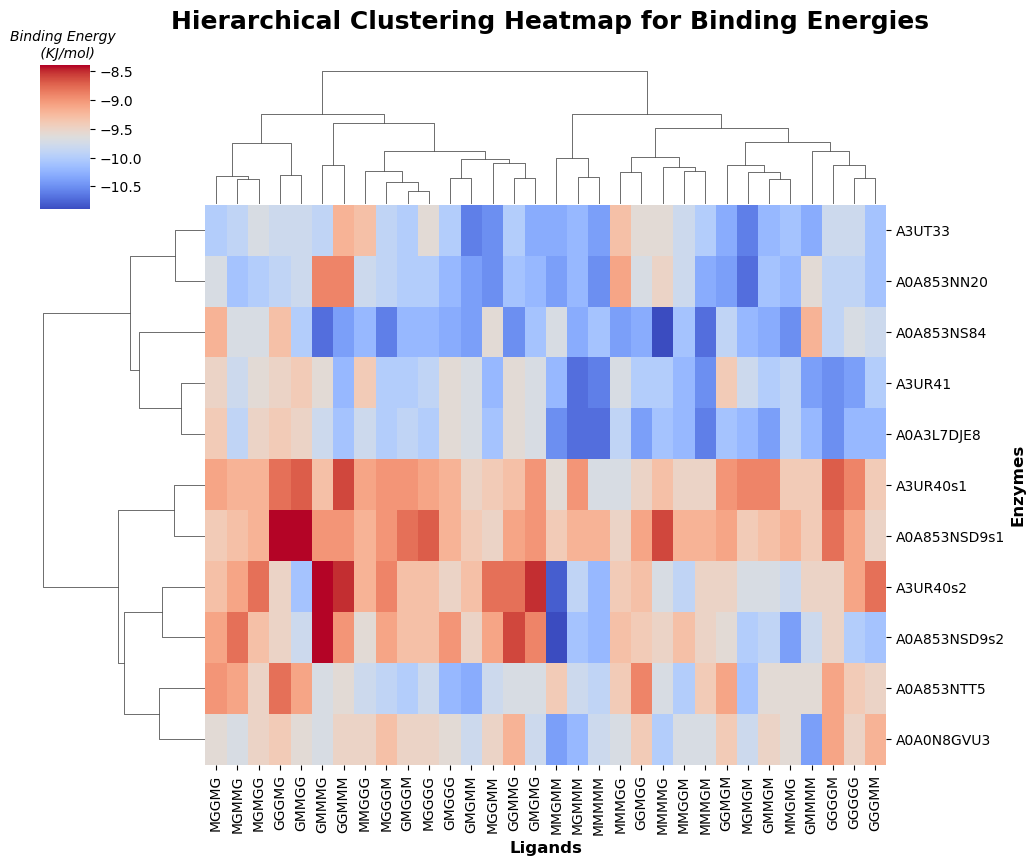

In [4]:
# load in all enzymes and reorder to desired format
all_enzymeNames = ('A3UT33','A3UR41','A3UR40s1','A3UR40s2','A0A853NTT5','A0A853NS84','A0A0N8GVU3',
                   'A0A853NN20','A0A3L7DJE8','A0A853NSD9s1','A0A853NSD9s2')
A3UT33 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/A3UT33.txt",sep=","))
A3UR41 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/A3UR41.txt",sep=","))
A3UR40s1 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/csv_A3UR40_site1.txt",sep=","))
A3UR40s2 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/csv_A3UR40_site2.txt",sep=","))
A0A853NTT5 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/csv_A0A853NTT5.txt",sep=","))
A0A853NS84 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/csv_A0A853NS84.txt",sep=","))
A0A0N8GVU3 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/csv_A0A0N8GVU3.txt",sep=","))
A0A853NN20 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/csv_A0A853NN20.txt",sep=","))
A0A3L7DJE8 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/csv_A0A3L7DJE8.txt",sep=","))
A0A853NSD9s1 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/csv_A0A853NSD9_site1.txt",sep=","))
A0A853NSD9s2 = reorder_df(pd.read_csv("/Users/kevinliu/Desktop/Enzyme_Analysis/all_320_enzyme/csv_A0A853NSD9_site2.txt",sep=","))


# create consolidated dataframe of all enzymes and ligands, values represent the 95th percentile value
# to change percentile go to function and change parameters
combined_dict = {}
for name in all_enzymeNames:
    globals()[name] = apply_percentile(create_combined_binding_dict(globals()[name]))
    combined_dict[name] = globals()[name]

df = pd.DataFrame.from_dict(combined_dict, orient="index")

enzyme_info = pd.read_excel('/Users/kevinliu/Desktop/Enzyme_Analysis/enzyme_info.xlsx')
# print(enzyme_info.columns)
km_values = enzyme_info.iloc[:,[5,12]]

import scipy.cluster.hierarchy as sch

g = sns.clustermap(df, method="ward", metric="euclidean", cmap="coolwarm", figsize=(10, 8), dendrogram_ratio=(0.2, 0.2))

g.ax_heatmap.set_xlabel("Ligands", fontsize=12, fontweight="bold")
g.ax_heatmap.set_ylabel("Enzymes", fontsize=12, fontweight="bold")

plt.title("Binding Energy \n (KJ/mol)", fontsize=10, fontstyle='italic')
plt.suptitle("Hierarchical Clustering Heatmap for Binding Energies", fontsize=18, fontweight="bold", y=1.05, x = 0.53)
plt.show()

## Load in binding energy and km scores

In [5]:
enzyme_info = pd.read_excel('enzyme_info.xlsx')
# print(enzyme_info.columns)
km_values = enzyme_info.iloc[:,[5,12]]

# load in all enzymes and reorder to desired format
all_enzymeNames = ('A3UT33','A3UR41','A3UR40s1','A3UR40s2','A0A853NTT5','A0A853NS84','A0A0N8GVU3',
                   'A0A853NN20','A0A3L7DJE8','A0A853NSD9s1','A0A853NSD9s2')
A3UT33 = reorder_df(pd.read_csv("A3UT33.txt",sep=","))
A3UR41 = reorder_df(pd.read_csv("A3UR41.txt",sep=","))
A3UR40s1 = reorder_df(pd.read_csv("csv_A3UR40_site1.txt",sep=","))
A3UR40s2 = reorder_df(pd.read_csv("csv_A3UR40_site2.txt",sep=","))
A0A853NTT5 = reorder_df(pd.read_csv("csv_A0A853NTT5.txt",sep=","))
A0A853NS84 = reorder_df(pd.read_csv("csv_A0A853NS84.txt",sep=","))
A0A0N8GVU3 = reorder_df(pd.read_csv("csv_A0A0N8GVU3.txt",sep=","))
A0A853NN20 = reorder_df(pd.read_csv("csv_A0A853NN20.txt",sep=","))
A0A3L7DJE8 = reorder_df(pd.read_csv("csv_A0A3L7DJE8.txt",sep=","))
A0A853NSD9s1 = reorder_df(pd.read_csv("csv_A0A853NSD9_site1.txt",sep=","))
A0A853NSD9s2 = reorder_df(pd.read_csv("csv_A0A853NSD9_site2.txt",sep=","))


# create combined dataframe with each iteration of data: rows~enzymes, columns~ligands
combined_df = pd.DataFrame()
for enzyme in all_enzymeNames:
    temp = create_combined_binding_dict(globals()[enzyme])
    temp = pd.DataFrame(temp)
    
    # insert enzyme name
    temp.insert(0,"Enzyme", [enzyme]*len(temp.iloc[:,0]))

    # insert km values
    km = pair_km_enzyme(enzyme, km_values)
    temp.insert(1,"KM", [km]*len(temp.iloc[:,0]))

    combined_df= pd.concat([combined_df, temp], ignore_index=True)

"""
# rename enzyme to real name not alphafold id
for index in range(len(combined_df.loc[:,'Enzyme'])):
    name = combined_df.loc[index,'Enzyme']
    combined_df.loc[index,'Enzyme'] = index_map[name]
"""
combined_df

,Enzyme,KM,GMMMG,GMMMM,MMMMG,GGMMG,MGMMG,MGMGM,GGGGM,MGGMG,...,MMMGG,GGGMG,GGMMM,GGMGG,GGGMM,MMGGG,MMGMM,GMMGG,MMGGM,MMMGM
0,A3UT33,0.123,-9.3,-9.5,-8.8,-10.1,-8.2,-10.6,-9.8,-10.0,...,-9.0,-9.8,-9.2,-9.7,-10.1,-9.3,-9.8,-9.7,-9.9,-9.8
1,A3UT33,0.123,-9.3,-8.9,-8.8,-9.7,-8.2,-10.4,-9.7,-9.9,...,-8.8,-9.6,-8.9,-9.6,-9.8,-9.1,-9.7,-9.6,-9.8,-9.8
2,A3UT33,0.123,-9.3,-8.9,-8.7,-9.7,-8.1,-10.4,-9.7,-9.8,...,-8.8,-9.6,-8.7,-9.6,-9.7,-9.1,-9.6,-9.6,-9.7,-9.7
3,A3UT33,0.123,-9.2,-8.9,-8.6,-9.6,-8.0,-10.3,-9.6,-9.8,...,-8.7,-9.5,-8.6,-9.6,-9.6,-9.1,-9.6,-9.5,-9.6,-9.7
4,A3UT33,0.123,-9.1,-8.9,-8.6,-9.6,-8.0,-10.2,-9.5,-9.7,...,-8.7,-9.5,-8.6,-9.5,-9.6,-9.1,-9.6,-9.5,-9.6,-9.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,A0A853NSD9s2,0.090,-8.0,-9.5,-8.6,-8.2,-8.4,-9.6,-9.0,-8.6,...,-8.4,-8.7,-8.0,-9.2,-9.7,-9.1,-10.2,-9.4,-9.0,-8.8
986,A0A853NSD9s2,0.090,-8.0,-9.5,-8.6,-8.1,-8.4,-9.5,-9.0,-8.6,...,-8.3,-8.6,-8.0,-9.1,-9.6,-9.1,-10.2,-9.3,-8.9,-8.7
987,A0A853NSD9s2,0.090,-8.0,-9.5,-8.6,-8.1,-8.4,-9.4,-9.0,-8.6,...,-8.3,-8.5,-8.0,-9.0,-9.6,-9.0,-10.2,-9.2,-8.9,-8.7
988,A0A853NSD9s2,0.090,-7.9,-9.4,-8.5,-7.9,-8.3,-9.4,-8.9,-8.6,...,-8.1,-8.5,-8.0,-9.0,-9.5,-8.9,-10.1,-9.1,-8.8,-8.6


## Graph Stucture Data

In [6]:
from Bio.PDB import PDBParser
parser = PDBParser()

A3UT33_struc = parser.get_structure('protein', 'structures/AF-A3UT33-F1-model_v4.pdb')
A3UR41_struc = parser.get_structure('protein', 'structures/AF-A3UR41-F1-model_v4.pdb')
A3UR40s1_struc = parser.get_structure('protein', 'structures/AF-A3UR40-F1-model_v4.pdb')
A3UR40s2_struc = parser.get_structure('protein', 'structures/AF-A3UR40-F1-model_v4.pdb')
A0A853NTT5_struc = parser.get_structure('protein', 'structures/AF-A0A853NTT5-F1-model_v4.pdb')
A0A853NS84_struc = parser.get_structure('protein', 'structures/AF-A0A853NS84-F1-model_v4.pdb')
A0A0N8GVU3_struc = parser.get_structure('protein', 'structures/AF-A0A0N8GVU3-F1-model_v4.pdb')
A0A853NN20_struc = parser.get_structure('protein', 'structures/AF-A0A853NN20-F1-model_v4.pdb')
A0A3L7DJE8_struc = parser.get_structure('protein', 'structures/AF-A0A3L7DJE8-F1-model_v4.pdb')
A0A853NSD9s1_struc = parser.get_structure('protein', 'structures/AF-A0A853NSD9-F1-model_v4.pdb')
A0A853NSD9s2_struc = parser.get_structure('protein', 'structures/AF-A0A853NSD9-F1-model_v4.pdb')

structures = [A3UT33_struc,A3UR41_struc,A3UR40s1_struc,A3UR40s2_struc,A0A853NTT5_struc,A0A853NS84_struc,A0A0N8GVU3_struc,
         A0A853NN20_struc,A0A3L7DJE8_struc,A0A853NSD9s1_struc,A0A853NSD9s2_struc]

labels = [0.123,0.022,0.036,0.036,0.3,0.04,0.06,0.17,0.15,0.09,0.09]

In [7]:
# Create networks from PDB files
import networkx as nx

graphs = []  # list to store all graphs

for structure in structures:  # loop over list of structures
    G = nx.Graph()

    for model in structure:
        for chain in model:
            for residue in chain:
                res_id = residue.get_id()
                ca = residue['CA'] if 'CA' in residue else None  # use alpha carbon
                if ca:
                    G.add_node(res_id, coords=ca.get_coord())

    # Add edges based on distance
    cutoff = 5.0  # angstroms
    nodes = list(G.nodes(data=True))
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            dist = np.linalg.norm(nodes[i][1]['coords'] - nodes[j][1]['coords'])
            if dist < cutoff:
                G.add_edge(nodes[i][0], nodes[j][0], distance=dist)

    graphs.append(G)

from spektral.data import Graph, Dataset

class ProteinDataset(Dataset):
    def __init__(self, graphs, labels, **kwargs):
        self.graphs = graphs
        self.labels = labels
        super().__init__(**kwargs)

    def read(self):
        output = []
        for G, label in zip(self.graphs, self.labels):
            X = np.array([data['coords'] for _, data in G.nodes(data=True)])  # (n_nodes, 3)
            A = nx.to_numpy_array(G)  # (n_nodes, n_nodes)
            y = np.array([label])  # set the correct label
            output.append(Graph(x=X, a=A, y=y))
        return output

dataset = ProteinDataset(graphs, labels)

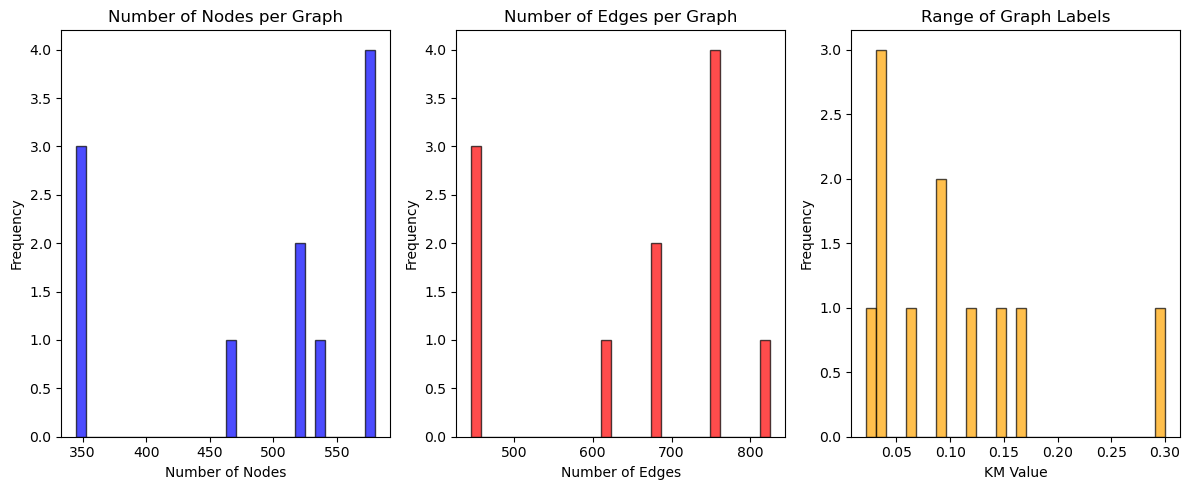

In [8]:
# brief overview of graphs in datset
nodes = []
edges = []
label = []
for graph in dataset:
    nodes.append(graph.n_nodes)
    edges.append(graph.n_edges//2)
    label.append(graph.y[0])

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].hist(nodes, bins=30, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Number of Nodes")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Number of Nodes per Graph")

axes[1].hist(edges, bins=30, color='red', edgecolor='black', alpha=0.7)
axes[1].set_xlabel("Number of Edges")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Number of Edges per Graph")

axes[2].hist(label, bins=30, color='orange', edgecolor='black', alpha=0.7)
axes[2].set_xlabel("KM Value")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Range of Graph Labels")

plt.tight_layout()
plt.show()

This is a brief overview of the data. Obviously there are very few graphs in this datset so the data is not the best. Overall, we can see that the graphs have a range of nodes and edges. Similarily, there are various Km values with some extremes that our model may need to be careful of.

## Model part I: Graph Neural Network for structure data

In [9]:
from sklearn.model_selection import train_test_split
from spektral.layers import GCNConv
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from spektral.data import Graph, Dataset, Loader
from spektral.layers import GlobalAvgPool, GlobalSumPool, GlobalMaxPool
from tensorflow.keras.optimizers import Adam

# Split indices for training and test sets
indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Define a custom Dataset wrapper to hold a list of graphs
class SubsetDataset(Dataset):
    def __init__(self, graphs, **kwargs):
        self._graphs = graphs
        super().__init__(**kwargs)

    def read(self):
        return self._graphs

# Create training and test datasets using the wrapper
train_graphs = [dataset[i] for i in train_idx]
test_graphs = [dataset[i] for i in test_idx]

train_dataset = SubsetDataset(train_graphs)
test_dataset = SubsetDataset(test_graphs)

print("Training graphs:", len(train_dataset))
print("Test graphs:", len(test_dataset))

# Now you can create DisjointLoaders without the 'signature' error:
from spektral.data.loaders import DisjointLoader

train_loader = DisjointLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DisjointLoader(test_dataset, batch_size=32, shuffle=False)

Training graphs: 8
Test graphs: 3


/opt/anaconda3/lib/python3.12/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'SubsetDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


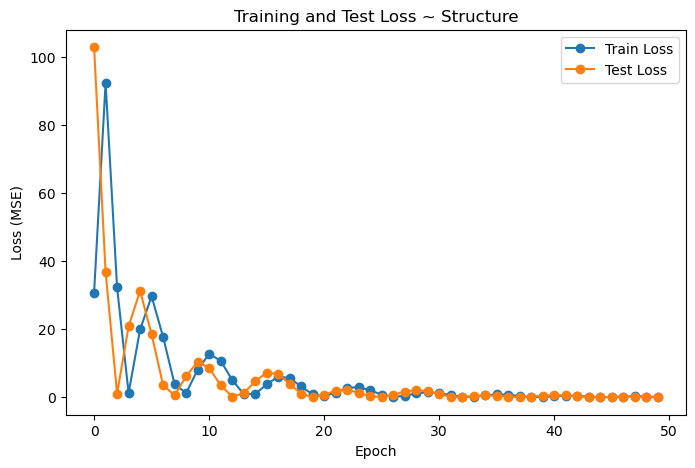

Test Loss: 0.0108
Model Loss: 0.09720964729785919


In [10]:
from spektral.layers import GCNConv
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAvgPool1D, Dense

class MyGCNConv(GCNConv):
    def compute_mask(self, inputs, mask=None):
        # Ignore mask propagation: always return None
        return None

    def call(self, inputs, **kwargs):
        # Remove mask and training kwargs if present:
        kwargs.pop('mask', None)
        kwargs.pop('training', None)
        return super().call(inputs, **kwargs)

    def compute_output_shape(self, input_shape):
        # input_shape is a tuple: (x_shape, a_shape)
        # x_shape: (num_nodes, n_features) → output: (num_nodes, channels)
        return (input_shape[0][0], self.channels)


def build_structure_model(n_node_features):
    # Define inputs for disjoint mode:
    x_in = Input(shape=(n_node_features,), name='node_features')
    a_in = Input(shape=(None,), sparse=True, name='adjacency_matrix')
    i_in = Input(shape=(), name='graph_index', dtype=tf.int32)
    
    # Use your custom convolution layers instead of the standard GCNConv:
    x = MyGCNConv(256, activation='relu')([x_in, a_in])
    x = MyGCNConv(128, activation='relu')([x, a_in])
    pool = GlobalAvgPool()([x, i_in])
    output = Dense(64, activation='relu')(pool)
    output = Dense(1, activation='linear')(output)
    
    return Model(inputs=[x_in, a_in, i_in], outputs=output, name='structure_model')

model = build_structure_model(dataset.n_node_features)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

"""
# Define inputs for disjoint mode:
x_in = Input(shape=(dataset.n_node_features,), name='node_features')
a_in = Input(shape=(None,), sparse=True, name='adjacency_matrix')
i_in = Input(shape=(), name='graph_index', dtype=tf.int32)

# Use your custom convolution layers instead of the standard GCNConv:
x = MyGCNConv(32, activation='relu')([x_in, a_in])
x = MyGCNConv(32, activation='relu')([x, a_in])
pool = GlobalAvgPool()([x, i_in])
output = Dense(128, activation='relu')(pool)
output = Dense(1, activation='linear')(output)

model = Model(inputs=[x_in, a_in, i_in], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
"""

# === Step 4: Train the Model ===
history = model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=50,
    validation_data=test_loader.load(),
    validation_steps=test_loader.steps_per_epoch,
    verbose = 0
)

# === Step 5: Plot Training and Validation History ===

plt.figure(figsize=(8, 5))

# Plot Loss
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss ~ Structure')
plt.legend()

plt.show()

test_loss, test_acc = model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print("Model Loss:", history.history['loss'][-1])

## Model part II: Feed Forward Neural Network for binding energy

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import BatchNormalization

# prepare the data and split into training and testing sets
x = combined_df.iloc[:,2:]
y = combined_df["KM"]

# min max normalization
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# split into training test sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)


def build_binding_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(16, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='linear')(x)  # regression output
    
    model = Model(inputs=inputs, outputs=outputs, name='build_binding_model')
    return model

# Create the model
model = build_binding_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # 'mae' = mean absolute error

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    verbose=0
)


In [14]:
# create all combinations to be tested
num_layers = [1,2,3]
nodes_per_layer = [16,64,128]
batch_size = [8,32,256]
batch_normalization = ["yes","no"]
dropout_rate = [0,0.1,0.5,0.9]

all_combos = []

for layer in num_layers:
    for node in nodes_per_layer:
        for batch in batch_size:
            for norm in batch_normalization:
                for drop in dropout_rate:
                    all_combos = all_combos + [[layer,node,batch,norm,drop]]

# Hyperparamter tuning runs
loss_values = []

# prepare the data and split into training and testing sets
x = combined_df.iloc[:,2:]
y = combined_df["KM"]

# min max normalization
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# split into training test sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

counter = 0
for parameters in all_combos:
    # define parameters
    layer = parameters[0]
    node = parameters[1]
    batch = parameters[2]
    norm = parameters[3]
    drop = parameters[4]

    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(node, activation='relu')(inputs)
    
    if norm:
        x = BatchNormalization()(x)
    if drop > 0.0:
        x = Dropout(drop)(x)

    if layer >= 2:
        x = Dense(node, activation='relu')(x)
        if norm:
            x = BatchNormalization()(x)
        if drop > 0.0:
            x = Dropout(drop)(x)
    
    if layer == 3:
        x = Dense(node, activation='relu')(x)
        if norm:
            x = BatchNormalization()(x)
        if drop > 0.0:
            x = Dropout(drop)(x)

    outputs = Dense(1, activation='linear')(x)  # regression output
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # 'mae' = mean absolute error

    history = model.fit(X_train, y_train, epochs=20, batch_size=batch, validation_data=(X_test, y_test),verbose = 0)
    
    test_loss = model.evaluate(X_test, y_test,verbose=0)

    loss = test_loss[0]

    loss_values = loss_values + [loss]

    print((f"\n{counter} Test Loss: {loss:.4f}\n"))
    counter += 1


0 Test Loss: 0.0092


1 Test Loss: 0.0030


2 Test Loss: 0.0084


3 Test Loss: 0.0061


4 Test Loss: 0.0030


5 Test Loss: 0.0028


6 Test Loss: 0.0050


7 Test Loss: 0.0055


8 Test Loss: 0.0128


9 Test Loss: 0.0096


10 Test Loss: 0.0048


11 Test Loss: 0.0548


12 Test Loss: 0.0259


13 Test Loss: 0.0050


14 Test Loss: 0.0138


15 Test Loss: 0.0077


16 Test Loss: 0.1833


17 Test Loss: 0.0566


18 Test Loss: 0.0182


19 Test Loss: 0.0320


20 Test Loss: 0.0097


21 Test Loss: 0.0305


22 Test Loss: 0.0108


23 Test Loss: 0.0475


24 Test Loss: 0.0046


25 Test Loss: 0.0029


26 Test Loss: 0.0026


27 Test Loss: 0.0049


28 Test Loss: 0.0026


29 Test Loss: 0.0017


30 Test Loss: 0.0029


31 Test Loss: 0.0046


32 Test Loss: 0.0129


33 Test Loss: 0.0049


34 Test Loss: 0.0044


35 Test Loss: 0.0060


36 Test Loss: 0.0080


37 Test Loss: 0.0044


38 Test Loss: 0.0032


39 Test Loss: 0.0078


40 Test Loss: 0.0145


41 Test Loss: 0.0066


42 Test Loss: 0.0080


43 Test Loss: 0.0168

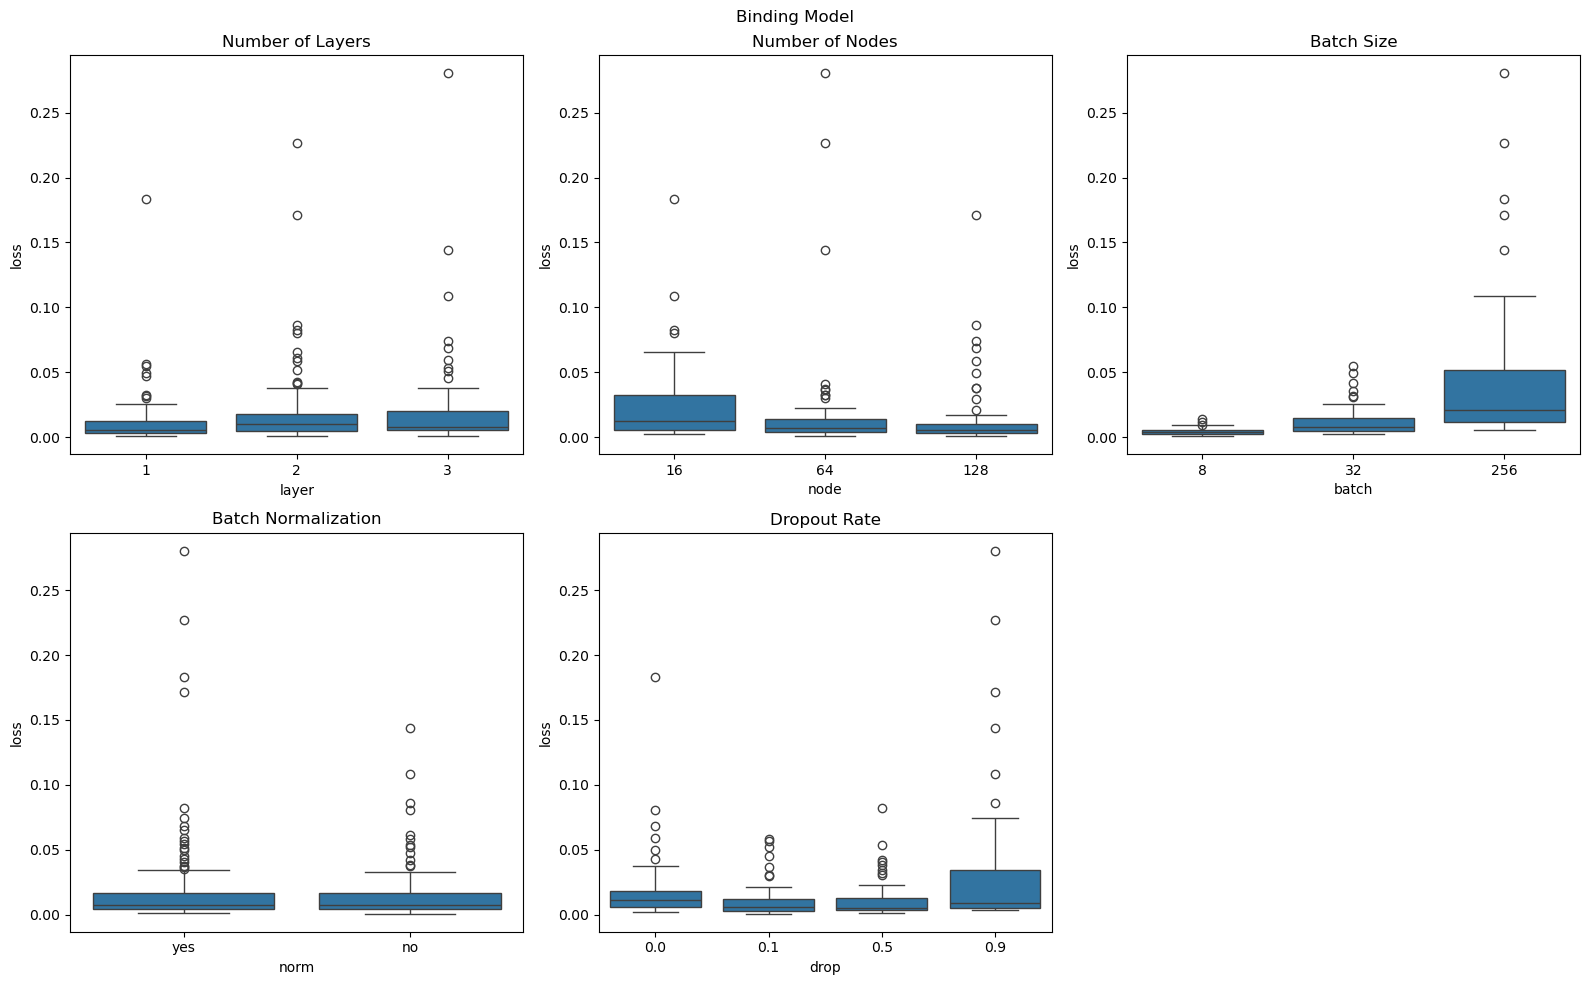

In [15]:
all_combos # 0,1,2,3,4
boxplot_dict = {} # key is hyper parameter, value is list of index
for index in range(len(all_combos)):
    for pos in range(0,5):
        if all_combos[index][pos] in boxplot_dict:
            boxplot_dict[all_combos[index][pos]].append(index)
        else:
            boxplot_dict[all_combos[index][pos]] = []
            boxplot_dict[all_combos[index][pos]].append(index)

for key in boxplot_dict.keys():
    loss_list = []
    for index in boxplot_dict[key]:
        loss_list.append(loss_values[index])
    boxplot_dict[key] = loss_list

# 1. Convert all results into a DataFrame
results_df = pd.DataFrame(all_combos, columns=['layer', 'node', 'batch', 'norm', 'drop'])
results_df['loss'] = loss_values

# 2. Now plot a boxplot for each hyperparameter separately
plt.figure(figsize=(16, 10))

# Plot for number of layers
plt.subplot(2, 3, 1)
sns.boxplot(data=results_df, x='layer', y='loss')
plt.title('Number of Layers')

# Plot for number of nodes
plt.subplot(2, 3, 2)
sns.boxplot(data=results_df, x='node', y='loss')
plt.title('Number of Nodes')

# Plot for batch size
plt.subplot(2, 3, 3)
sns.boxplot(data=results_df, x='batch', y='loss')
plt.title('Batch Size')

# Plot for normalization (True/False)
plt.subplot(2, 3, 4)
sns.boxplot(data=results_df, x='norm', y='loss')
plt.title('Batch Normalization')

# Plot for dropout rate
plt.subplot(2, 3, 5)
sns.boxplot(data=results_df, x='drop', y='loss')
plt.title('Dropout Rate')

plt.suptitle('Binding Model')
plt.tight_layout()
plt.show()

The best hyperparameters are 1 layers, 128 nodes, 8 batch size, yes normalization, and 0.5 drop out rate

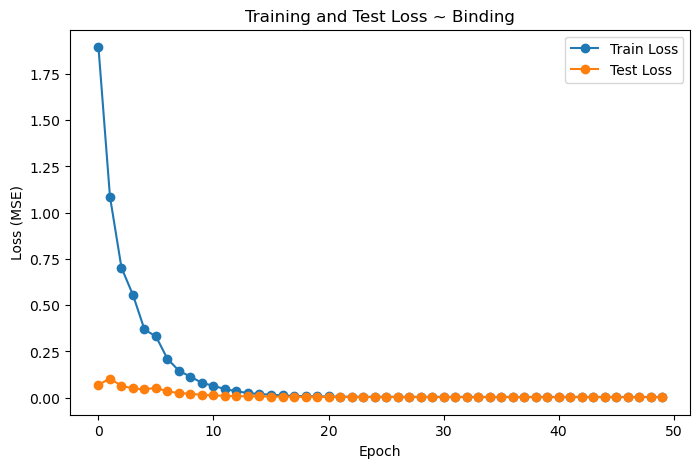

Model Loss: 0.0046902005560696125


In [17]:
# observing loss for tuned model
x = combined_df.iloc[:,2:]
y = combined_df["KM"]

# min max normalization
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# split into training test sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

binding_model = build_binding_model(X_train.shape[1],)
binding_model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # 'mae' = mean absolute error

history = binding_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test),verbose = 0)

plt.figure(figsize=(8, 5))

# Plot Loss
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss ~ Binding')
plt.legend()

plt.show()
print("Model Loss:", history.history['loss'][-1])

## Model part III: Feed Forward Neural Network for ligand composition

In [18]:
# prepare one-hot-encoded dataframe of ligands
ligand_df = combined_df.copy()
# For every ligand column, replace its values with its column name
for ligand in ligand_df.columns[2:]:  # again, skip 'Enzyme' and 'KM'
    ligand_df[ligand] = ligand

ligand_df = ligand_df.drop_duplicates().reset_index(drop=True)

def one_hot_encode(ligand):
    # if G then 0, if M then 1
    value = []
    for c in ligand:
        if c =='G':
            value.append(0)
        else:
            value.append(1)
    return value


ligand_columns = ligand_df.columns[2:]  # Exclude 'Enzyme' and 'KM' columns

# Apply the one_hot_encode function to each ligand column
for col in ligand_columns:
    ligand_df[col] = ligand_df[col].apply(one_hot_encode)

In [26]:
def build_ligand_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    output = Dense(1, activation='linear')(x)
    return Model(inputs=inputs, outputs=output, name='ligand_model')

In [20]:
# create all combinations to be tested
num_layers = [1,2,3]
nodes_per_layer = [16,64,128]
batch_size = [8,32,256]
batch_normalization = ["yes","no"]
dropout_rate = [0,0.1,0.5,0.9]

all_combos = []

for layer in num_layers:
    for node in nodes_per_layer:
        for batch in batch_size:
            for norm in batch_normalization:
                for drop in dropout_rate:
                    all_combos = all_combos + [[layer,node,batch,norm,drop]]

# Hyperparamter tuning runs
loss_values = []

# prepare the data and split into training and testing sets
x = ligand_df.iloc[:,2:]
y = ligand_df["KM"].values
X = np.array(x.apply(lambda row: np.concatenate(row.values), axis=1).tolist())

# split into training test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

counter = 0
for parameters in all_combos:
    # define parameters
    layer = parameters[0]
    node = parameters[1]
    batch = parameters[2]
    norm = parameters[3]
    drop = parameters[4]

    input_dim = X_train.shape[1]
    inputs = Input(shape=(input_dim,))
    x = Dense(node, activation='relu')(inputs)
    
    if norm:
        x = BatchNormalization()(x)
    if drop > 0.0:
        x = Dropout(drop)(x)

    if layer >= 2:
        x = Dense(node, activation='relu')(x)
        if norm:
            x = BatchNormalization()(x)
        if drop > 0.0:
            x = Dropout(drop)(x)
    
    if layer == 3:
        x = Dense(node, activation='relu')(x)
        if norm:
            x = BatchNormalization()(x)
        if drop > 0.0:
            x = Dropout(drop)(x)

    outputs = Dense(1, activation='linear')(x)  # regression output
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # 'mae' = mean absolute error

    history = model.fit(X_train, y_train, epochs=50, batch_size=batch, validation_data=(X_test, y_test),verbose = 0)
    
    test_loss = model.evaluate(X_test, y_test,verbose=0)

    loss = test_loss[0]

    loss_values = loss_values + [loss]

    print((f"\n{counter} Test Loss: {loss:.4f}\n"))
    counter += 1


0 Test Loss: 0.6826


1 Test Loss: 0.5048


2 Test Loss: 1.3582


3 Test Loss: 0.2912


4 Test Loss: 0.0102


5 Test Loss: 0.1051


6 Test Loss: 0.2310


7 Test Loss: 0.0019


8 Test Loss: 0.0206


9 Test Loss: 1.2638


10 Test Loss: 1.6705


11 Test Loss: 0.0812


12 Test Loss: 0.2434


13 Test Loss: 0.6887


14 Test Loss: 0.7623


15 Test Loss: 0.0691


16 Test Loss: 0.0143


17 Test Loss: 0.4755


18 Test Loss: 0.0751


19 Test Loss: 0.3439


20 Test Loss: 2.0421


21 Test Loss: 0.4829


22 Test Loss: 0.3395


23 Test Loss: 0.2992


24 Test Loss: 0.0012


25 Test Loss: 0.0035


26 Test Loss: 1.9105


27 Test Loss: 0.0323


28 Test Loss: 0.2482


29 Test Loss: 0.7040


30 Test Loss: 0.0404


31 Test Loss: 0.9193


32 Test Loss: 1.2004


33 Test Loss: 0.1814


34 Test Loss: 0.2956


35 Test Loss: 0.5512


36 Test Loss: 0.0650


37 Test Loss: 0.0012


38 Test Loss: 0.4670


39 Test Loss: 0.0196


40 Test Loss: 0.4928


41 Test Loss: 1.5946


42 Test Loss: 0.2112


43 Test Loss: 0.0125

Ligands


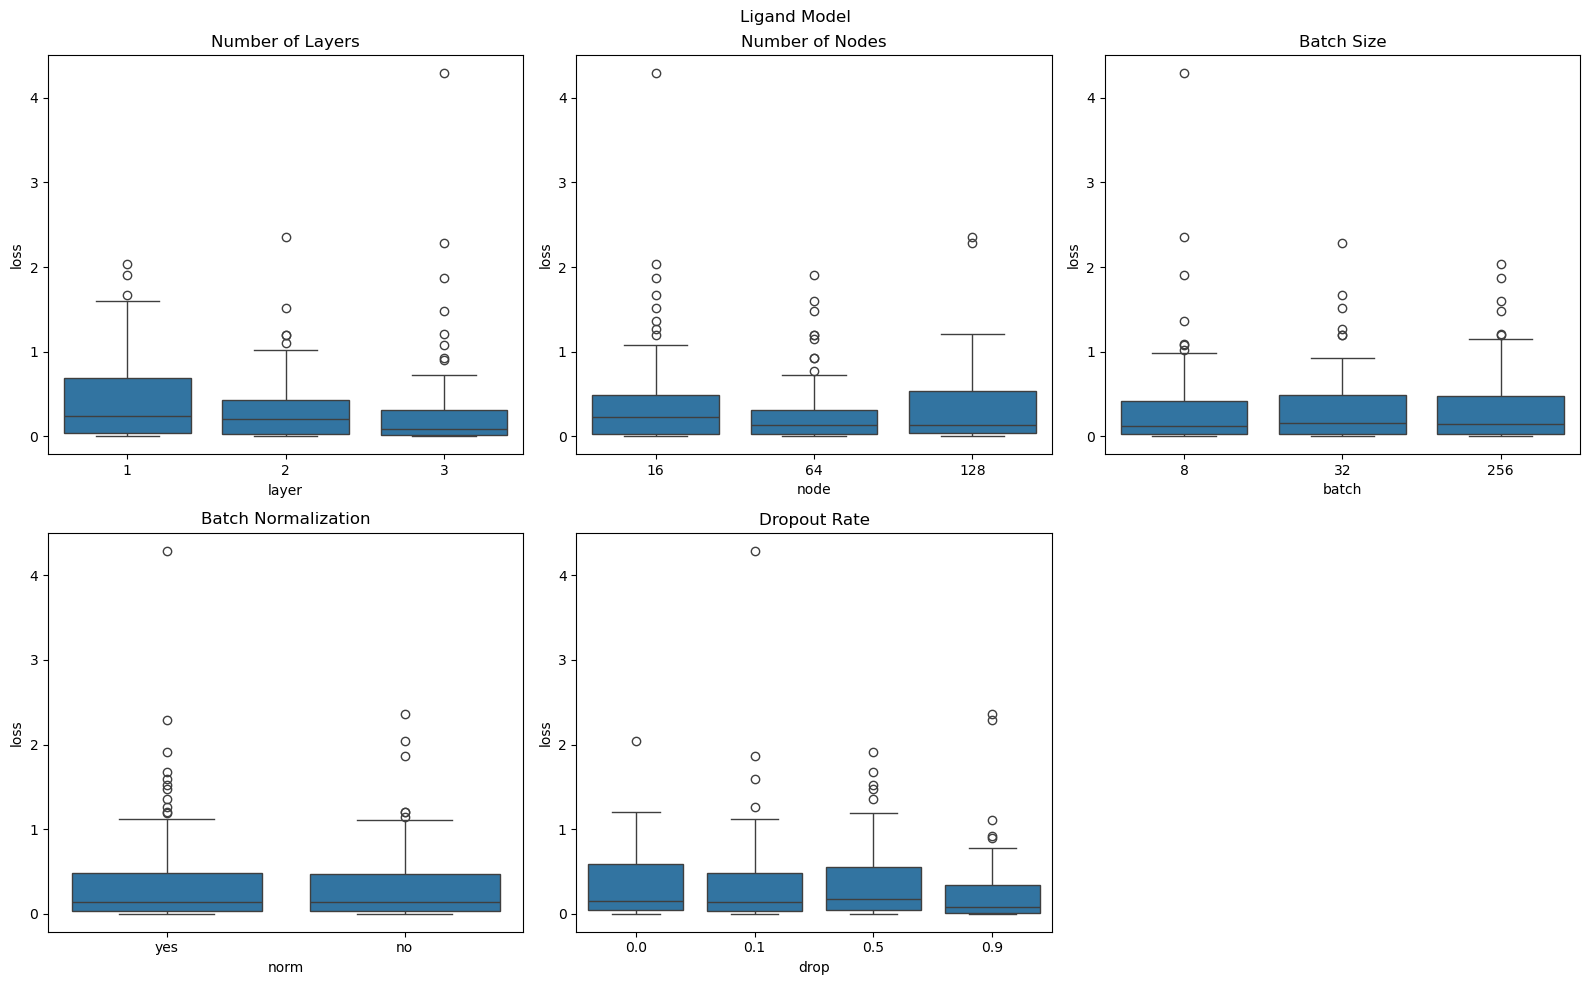

In [21]:
all_combos # 0,1,2,3,4
boxplot_dict = {} # key is hyper parameter, value is list of index
for index in range(len(all_combos)):
    for pos in range(0,5):
        if all_combos[index][pos] in boxplot_dict:
            boxplot_dict[all_combos[index][pos]].append(index)
        else:
            boxplot_dict[all_combos[index][pos]] = []
            boxplot_dict[all_combos[index][pos]].append(index)

for key in boxplot_dict.keys():
    loss_list = []
    for index in boxplot_dict[key]:
        loss_list.append(loss_values[index])
    boxplot_dict[key] = loss_list

# 1. Convert all results into a DataFrame
results_df = pd.DataFrame(all_combos, columns=['layer', 'node', 'batch', 'norm', 'drop'])
results_df['loss'] = loss_values

# 2. Now plot a boxplot for each hyperparameter separately
print('Ligands')
plt.figure(figsize=(16, 10))

# Plot for number of layers
plt.subplot(2, 3, 1)
sns.boxplot(data=results_df, x='layer', y='loss')
plt.title('Number of Layers')

# Plot for number of nodes
plt.subplot(2, 3, 2)
sns.boxplot(data=results_df, x='node', y='loss')
plt.title('Number of Nodes')

# Plot for batch size
plt.subplot(2, 3, 3)
sns.boxplot(data=results_df, x='batch', y='loss')
plt.title('Batch Size')

# Plot for normalization (True/False)
plt.subplot(2, 3, 4)
sns.boxplot(data=results_df, x='norm', y='loss')
plt.title('Batch Normalization')

# Plot for dropout rate
plt.subplot(2, 3, 5)
sns.boxplot(data=results_df, x='drop', y='loss')
plt.title('Dropout Rate')

plt.suptitle('Ligand Model')
plt.tight_layout()
plt.show()

The best hyperparameters are 3 layers, 128 nodes, 8 batch size, yes normalization, 0.1 drop

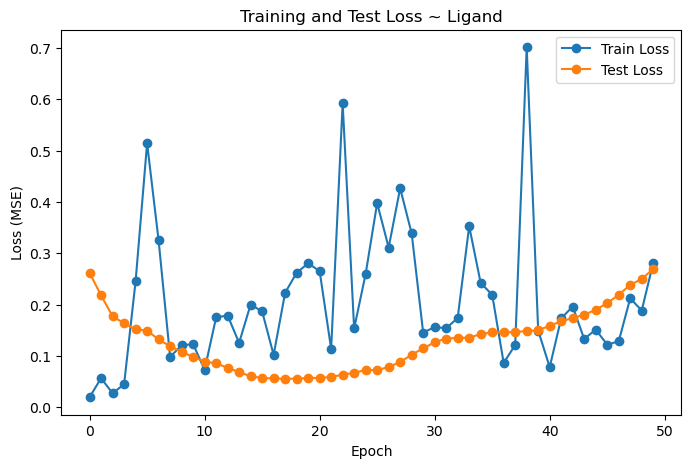

Model Loss: 0.2813023030757904


In [34]:
ligand_x_raw = ligand_df.iloc[:, 2:]
ligand_y = ligand_df["KM"].values
ligand_x = np.array(ligand_x_raw.apply(lambda row: np.concatenate(row.values), axis=1).tolist())
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(ligand_x, ligand_y, test_size=0.2, random_state=42)
ligand_model = build_ligand_model(X_train_l.shape[1])
ligand_model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # 'mae' = mean absolute error
history = ligand_model.fit(X_train_l, y_train_l, epochs=50, batch_size=8, validation_data=(X_test_l, y_test_l),verbose = 0)

plt.figure(figsize=(8, 5))

# Plot Loss
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss ~ Ligand')
plt.legend()

plt.show()
print("Model Loss:", history.history['loss'][-1])

## Fusion Model

In [35]:
from spektral.layers import GCNConv
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAvgPool1D, Dense

# Structure model
def build_structure_model(n_node_features):
    # Define inputs for disjoint mode:
    x_in = Input(shape=(n_node_features,), name='node_features')
    a_in = Input(shape=(None,), sparse=True, name='adjacency_matrix')
    i_in = Input(shape=(), name='graph_index', dtype=tf.int32)
    
    # Use your custom convolution layers instead of the standard GCNConv:
    x = MyGCNConv(32, activation='relu')([x_in, a_in])
    x = MyGCNConv(32, activation='relu')([x, a_in])
    pool = GlobalAvgPool()([x, i_in])
    output = Dense(128, activation='relu')(pool)
    output = Dense(1, activation='linear')(output)

    return Model(inputs=[x_in, a_in, i_in], outputs=output, name='structure_model')

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

def build_binding_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(16, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='linear')(x)  # regression output
    
    return Model(inputs=inputs, outputs=outputs, name='binding_model')

def build_ligand_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    output = Dense(1, activation='linear')(x)
    return Model(inputs=inputs, outputs=output, name='ligand_model')

from tensorflow.keras.layers import Concatenate

In [40]:
"""pretraining models"""
# structure model
structure_model = build_structure_model(dataset.n_node_features)
structure_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
structure_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=50,
    validation_data=test_loader.load(),
    validation_steps=test_loader.steps_per_epoch,
    verbose = 0
)

# binding model
x = combined_df.iloc[:,2:]
y = combined_df["KM"]
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)
binding_model = build_binding_model(X_train.shape[1],)
binding_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
binding_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test),verbose = 0)

# binding model
ligand_x_raw = ligand_df.iloc[:, 2:]
ligand_y = ligand_df["KM"].values
ligand_x = np.array(ligand_x_raw.apply(lambda row: np.concatenate(row.values), axis=1).tolist())
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(ligand_x, ligand_y, test_size=0.2, random_state=42)
ligand_model = build_ligand_model(X_train_l.shape[1])
ligand_model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # 'mae' = mean absolute error
ligand_model.fit(X_train_l, y_train_l, epochs=50, batch_size=8, validation_data=(X_test_l, y_test_l),verbose = 0)

print('complete')

complete


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/lib/python3.12/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'SubsetDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


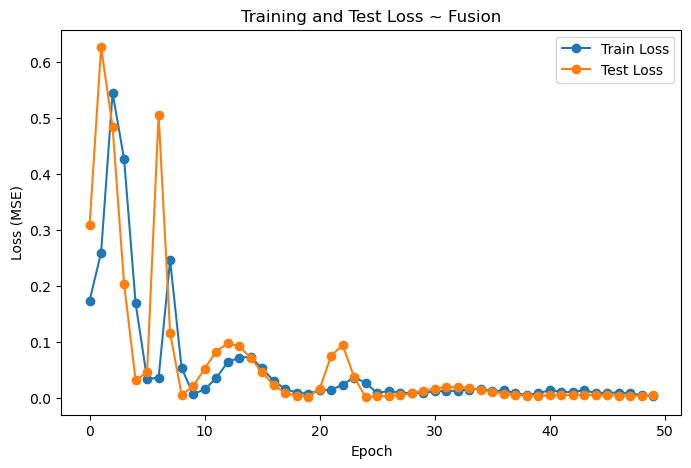

Model Loss: 0.0032743620686233044


In [41]:
class FusionDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, graph_loader, binding_data, ligand_data):
        self.graph_loader = graph_loader
        self.binding_data = binding_data
        self.ligand_data = ligand_data
        self.loader_iter = iter(self.graph_loader)
        self.steps_per_epoch = self.graph_loader.steps_per_epoch

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        try:
            (x, a, i), y = next(self.loader_iter)
        except StopIteration:
            self.loader_iter = iter(self.graph_loader)
            (x, a, i), y = next(self.loader_iter)
    
        indices = np.unique(i.numpy() if hasattr(i, "numpy") else i)
        binding_batch = self.binding_data[indices]
        ligand_batch = self.ligand_data[indices]
    
        return {
            'node_features': x,
            'adjacency_matrix': a,
            'graph_index': i,
            'binding_input': binding_batch,
            'ligand_input': ligand_batch
        }, y

# Define inputs
structure_input = [
    Input(shape=(dataset.n_node_features,), name='node_features'),      # x_in
    Input(shape=(None,), sparse=True, name='adjacency_matrix'),         # a_in
    Input(shape=(), dtype=tf.int32, name='graph_index')                 # i_in
]
binding_input = Input(shape=(X_train.shape[1],), name="binding_input")
ligand_input = Input(shape=(X_train_l.shape[1],), name="ligand_input")

# Get outputs by passing inputs through submodels
structure_out = structure_model(structure_input)
binding_out = binding_model(binding_input)
ligand_out = ligand_model(ligand_input)

# Concatenate outputs
concat = Concatenate()([structure_out, binding_out, ligand_out])
x = Dense(16, activation='relu')(concat)
final_output = Dense(1)(x)

# Define the final fusion model
fusion_model = Model(
    inputs={
        'node_features': structure_input[0],
        'adjacency_matrix': structure_input[1],
        'graph_index': structure_input[2],
        'binding_input': binding_input,
        'ligand_input': ligand_input
    },
    outputs=final_output
)

# Compile the fusion model
fusion_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
train_gen = FusionDataGenerator(train_loader, X_train, X_train_l)
test_gen = FusionDataGenerator(test_loader, X_test, X_test_l)
history = fusion_model.fit(
    train_gen,
    epochs=50,
    validation_data=test_gen,  # if you build a similar val generator
    verbose=0
)

plt.figure(figsize=(8, 5))

# Plot Loss
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss ~ Fusion')
plt.legend()

plt.show()
print("Model Loss:", history.history['loss'][-1])